# Reading business cards

You are trying to highlights specific region of a business cards to send it to an OCR...

The default find contours just makes you crazy .. and you are not sure you want to play with OpenCV anymore ...
this recipe is for you.

In [1]:
(ns sunset-firefly
(:require
 [opencv4.core :refer :all]
 [opencv4.utils :as u]))

nil

Start by reading the bizcard as an image.

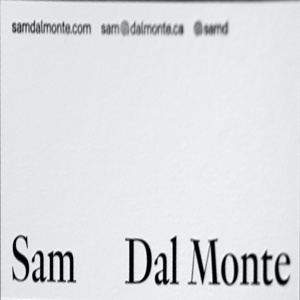

In [2]:
(def original
  (-> "resources/images/bizcard.png"
  imread
  (u/resize-by 0.3)))

(u/>>> original)

Let's naively find out what the contours are and draw them on a copy of the origina.

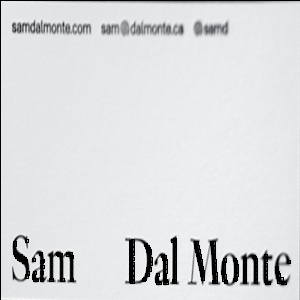

In [3]:
(def contours 
  (new-arraylist))

(find-contours 
  (-> original clone (cvt-color! COLOR_RGB2GRAY)) 
  contours 
  (new-mat) 
  RETR_LIST CHAIN_APPROX_SIMPLE)

(def result
  (-> original clone))

(doseq [c contours]
  (let [ rect (bounding-rect c)]
     (do
      (rectangle result
       (new-point (.x rect) (.y rect ))
       (new-point (+ (.width rect) (.x rect)) (+ (.y rect) (.height rect)))
       (new-scalar 0 0 0)
       1
       ))))

(u/>>> result)

Hmm .. that did not work whatsoever. There are so many contours that it just feels like you are drawing the letters themselves with rectangles ... let's try something else.
We will blur the image before apply a binary threshold, and then dilate the result just a bit. 

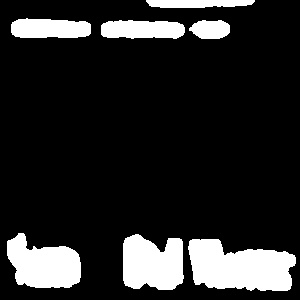

In [5]:
(def work
  (-> original
   clone
   (cvt-color! COLOR_RGB2GRAY)
   (gaussian-blur! (new-size 17 17) 50)
   (threshold! -1 255 (+ THRESH_BINARY_INV THRESH_OTSU))
   (dilate! (get-structuring-element MORPH_RECT (new-size 2 2)))))

(u/>>> work)

Then go back and find those contours again.

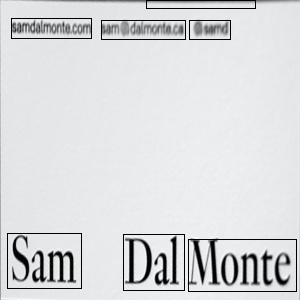

In [6]:
(def contours 
  (new-arraylist))
(find-contours work contours (new-mat) RETR_LIST CHAIN_APPROX_SIMPLE)

(def result
  (clone original))

(doseq [c contours]
  (let [ rect (bounding-rect c)]
      (rectangle result
       (new-point (.x rect) (.y rect ))
       (new-point (+ (.width rect) (.x rect)) (+ (.y rect) (.height rect)))
       (new-scalar 0 0 0)
       1
       )))

(u/>>> result )

Almost there ... let's get rid of the small artefact at the top of the business card, by selecting contours with a bounding box bigger than a given size, here 15.

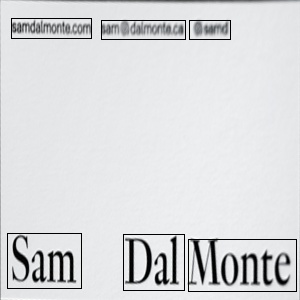

In [7]:
(def result
  (clone original))

(doseq [c (filter #(> (.height (bounding-rect %)) 15) contours)]
  (let [ rect (bounding-rect c)]
      (rectangle 
        result
       (new-point (.x rect) (.y rect ))
       (new-point (+ (.width rect) (.x rect)) (+ (.y rect) (.height rect)))
       (new-scalar 0 0 0)
       1
       )))

(u/>>> result)